In [1]:
# run nrnivmodl in the mechanisms folder, and then drag arm64 folder back out into Nav12_analysis folder
# changed ena to 55 mV in all sections (manually in biophysics.hoc)

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

tick_major = 6
tick_minor = 4
plt.rcParams["xtick.major.size"] = tick_major
plt.rcParams["xtick.minor.size"] = tick_minor
plt.rcParams["ytick.major.size"] = tick_major
plt.rcParams["ytick.minor.size"] = tick_minor

font_small = 12
font_medium = 13
font_large = 14
plt.rc('font', size=font_small)          # controls default text sizes
plt.rc('axes', titlesize=font_medium)    # fontsize of the axes title
plt.rc('axes', labelsize=font_medium)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=font_small)    # fontsize of the tick labels
plt.rc('ytick', labelsize=font_small)    # fontsize of the tick labels
plt.rc('legend', fontsize=font_small)    # legend fontsize
plt.rc('figure', titlesize=font_large)   # fontsize of the figure title

import matplotlib.colors as clr

In [2]:
from neuron import h
h.load_file("runModelL23.hoc")

	1 
	1 
Setting temperature to 34.000000 C
Setting simulation time step to 0.100000 ms
	1 
	1 
	1 
	1 
	1 
	1 
	1 
	1 
	1 
	1 
	1 
	1 
	1 
**********************
cADpyr229_L23_PC_5ecbf9b163[0].soma[0]
1 
1 
1 
	1 
	1 
	1 


1.0

In [3]:
def init_settings(nav12=1,
                  nav16=1,
                  dend_nav12=1, 
                  soma_nav12=1, 
                  ais_nav12=1, 
                  dend_nav16=1, 
                  soma_nav16=1,
                  ais_nav16=1, 
                  axon_Kp=1,
                  axon_Kt =1,
                  axon_K=1,
                  soma_K=1,
                  dend_K=1,
                  gpas_all=1):
    
    # create default model parameters to avoid loading the model
    
    h.dend_na12 = 0.026145/2 
    h.dend_na16 = h.dend_na12 
    h.dend_k = 0.004226 * soma_K


    h.soma_na12 = 0.983955/10 
    h.soma_na16 = h.soma_na12 
    h.soma_K = 0.303472 * soma_K

    h.ais_na16 = 4 
    h.ais_na12 = 4 
    h.ais_ca = 0.000990
    h.ais_KCa = 0.007104

    h.node_na = 2

    h.axon_KP = 0.973538 * axon_Kp
    h.axon_KT = 0.089259 * axon_Kt
    h.axon_K = 1.021945 * axon_K

    h.cell.axon[0].gCa_LVAstbar_Ca_LVAst = 0.001376286159287454
    
    #h.soma_na12 = h.soma_na12/2
    h.naked_axon_na = h.soma_na16/5
    h.navshift = -10
    h.myelin_na = h.naked_axon_na
    h.myelin_K = 0.303472
    h.myelin_scale = 10
    h.gpas_all = 3e-5 * gpas_all
    h.cm_all = 1
    
    
    h.dend_na12 = h.dend_na12 * nav12 * dend_nav12
    h.soma_na12 = h.soma_na12 * nav12 * soma_nav12
    h.ais_na12 = h.ais_na12 * nav12 * ais_nav12
    
    h.dend_na16 = h.dend_na16 * nav16 * dend_nav16
    h.soma_na16 = h.soma_na16 * nav16 * soma_nav16
    h.ais_na16 = h.ais_na16 * nav16 * ais_nav16
       
    
    h.working()

In [61]:
def init_stim(sweep_len = 300, stim_start = 100, stim_dur = 500, amp = 0.15, dt = 0.01):
    # updates the stimulation params used by the model
    # time values are in ms
    # amp values are in nA
    
    h("st.del = " + str(stim_start))
    h("st.dur = " + str(stim_dur))
    h("st.amp = " + str(amp))
    h.tstop = sweep_len
    h.dt = dt

In [5]:
def run_model(start_Vm = -80):

    h.finitialize(start_Vm)
    timesteps = int(h.tstop/h.dt)
    
    Vm = np.zeros(timesteps)
    I = {}
    I['Na'] = np.zeros(timesteps)
    I['Ca'] = np.zeros(timesteps)
    I['K'] = np.zeros(timesteps)
    I['GABA'] = np.zeros(timesteps)
    t = np.zeros(timesteps)

    for ii in range(timesteps):
        Vm[ii] = h.cell.soma[0].v
        I['Na'][ii] = h.cell.soma[0](0.5).ina
        I['Ca'][ii] = h.cell.soma[0](0.5).ica
        I['K'][ii] = h.cell.soma[0](0.5).ik
        for syn in syns:
            I['GABA'][ii] += syn.i
        t[ii] = ii*h.dt / 1000
        h.fadvance()
     
    ## if GABA currents are present, measure them -- does this work as expected?

#     ivecs = [] # for the individual synaptic currents
#     for abc in syns:
#         tmp = h.Vector()
#         tmp.record(abc._ref_i)
#         ivecs.append(tmp)
            
#     iGABA = np.zeros(timesteps)
#     for abc in ivecs:
#         iGABA += abc.as_numpy()
        
    return Vm, I, t

In [6]:
def detect_spikes(Vm, time, dVdt_thresh = 15, min_spike_len = 0.0002, properties=True):
    '''
    Method for identifying spikes based on rates of change in the membrane potential
    INPUTS:
    Vm: array-like - membrane potential (mV)
    time: array-like - time corresponding to Vm (sec)
    dVdt_thresh: float - Threshold for determining spike initiation (V/s)
    min_spike_len: float - Minimum length of time dVdt must be above dVdt_thresh to be considered a spike (sec)
    properties: Bool - If true, returns spike_times and spike_properties. Otherwise returns only spike_properties

    Output:
    array of spike times

    Identification of spike start times:
    dVdt is first quanitified from Vm and time
    Continuous stretches (runs) of dVdt above dVdt_thresh are identified, and then ensured to last longer than min_spike_len

    Spike Property measurement:
    spike_end is determined by finding the second zero crossing of dVdt after spike dVdt_threshold
    First zero crossing is AP peak, second should be end of repolarization phase
    Persistent zero crossing (must stay above zero for 3 continous points) is used to make sure that noise in slowly repolarizing spikes doesn't trigger spike end
    '''
    if len(Vm) != len(time):
        raise Exception("Vm and time must be the same length")

    #determine stretches where dVdt exceeds dVdt_thresh
    dVdt = np.gradient(Vm,time)/1e3
    runs = group_consecutives(np.argwhere((dVdt>=dVdt_thresh)).flatten())

    #If runs are longer than min_spike_len count as a spike
    dt = time[1]-time[0] #sample rate
    min_run_len = np.ceil(min_spike_len/dt)
    spike_times = []
    for run in runs:
        if len(run) > min_run_len:
            spike_times.append(time[run[0]])
    spike_times = np.asarray(spike_times)

    if not properties: #just return spike_times
        return spike_times

    #get spike properties
    spike_properties=[]
    for spike_time in spike_times:
        #find index of spike_time in time
        spike_start_idx = np.argwhere(spike_time == time)[0][0]

        #find zero crossings of dVdt after spike dVdt_threshold
        zero_crosses = find_zero_crossing(dVdt[spike_start_idx:-1])
        #make sure zero cross is persistent to account for noise
        if len(zero_crosses) > 1:
            spike_end_idx = spike_start_idx\
                            + zero_crosses[np.argwhere(np.diff(zero_crosses)>3)[0] + 1][0]
        else: #Vm ends before spike can repolarize, therefore assigned Vm[-1] as spike end
            spike_end_idx = len(Vm)-1

        spike_Vm = Vm[spike_start_idx:spike_end_idx]
        spike_time = time[spike_start_idx:spike_end_idx] - time[spike_start_idx]
        spike_dVdt = dVdt[spike_start_idx:spike_end_idx]
        spike = {}
        spike['start_idx'] = spike_start_idx
        spike['start_time'] = time[spike_start_idx]
        spike['end_idx'] = spike_end_idx
        spike['end_time'] = time[spike_end_idx]
        spike['Vm'] = spike_Vm
        spike['time'] = spike_time
        spike['thresh'] = spike_Vm[0]
        spike['peak_Vm'] = spike_Vm.max()
        spike['height'] = np.max(spike_Vm)-spike_Vm[0]
        spike['AHP'] = spike_Vm[0]-spike_Vm[-1]
        spike['peak_dVdt'] = spike_dVdt.max()
        spike['min_dVdt'] = spike_dVdt.min()
        try:
            half_pnts = find_zero_crossing(spike_Vm - (spike_Vm[0]+(np.max(spike_Vm)-spike_Vm[0])/2))
            spike['half_width'] = (half_pnts[1]-half_pnts[0])*dt*1000
        except: #For slowly repolarizing spikes this can sometimes fail
            spike['half_width'] = np.nan

        spike_properties.append(spike)
    return spike_times,spike_properties

def detect_spike_times(Vm, time, dVdt_thresh = 15, min_spike_len = 0.0002):
    '''
    Wrapper of detect_spikes to only get spike times
    '''
    return detect_spikes(Vm, time,
                          dVdt_thresh = dVdt_thresh,
                          min_spike_len = min_spike_len,
                          properties=False)

def detect_spike_properties(Vm, time, dVdt_thresh = 15, min_spike_len = 0.0001):
    '''
    Wrapper of detect_spikes to only get spike properties
    '''
    return detect_spikes(Vm, time,
                          dVdt_thresh = dVdt_thresh,
                          min_spike_len = min_spike_len,
                          properties=True)[1]

def group_consecutives(vals, step=1):
    """Return list of consecutive lists of numbers from vals (number list)."""
    run = []
    result = [run]
    expect = None
    for v in vals:
        if (v == expect) or (expect is None):
            run.append(v)
        else:
            run = [v]
            result.append(run)
        expect = v + step
    return result

def find_zero_crossing(x):
    '''
    returns array of indicies before a zero crossing occur
    If your input array starts and stops with zeros, it will find a zero crossing at the beginning, but not at the end
    '''
    zero_crossings = np.where(np.diff(np.signbit(x)))[0]
    return zero_crossings

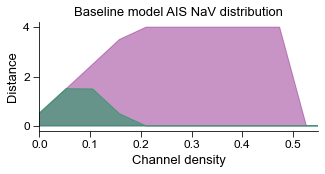

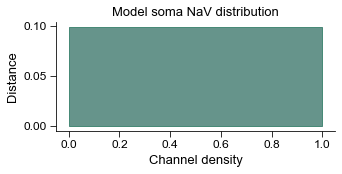

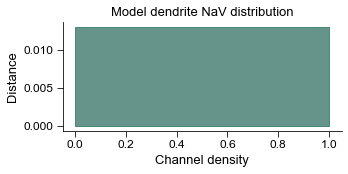

In [7]:

init_settings()

NaV12 = []
NaV16 = []
distance = []
nseg = h.cell.axon[0].nseg

# distance.append(-.4)
# distance.append(-.2)
# NaV12.append(h.dend_na12)
# NaV16.append(h.dend_na16)
# NaV12.append(h.dend_na12)
# NaV16.append(h.dend_na16)

# distance.append(-.2)
# distance.append(0)
# NaV12.append(h.soma_na12)
# NaV16.append(h.soma_na16)
# NaV12.append(h.soma_na12)
# NaV16.append(h.soma_na16)

for i in range(nseg):
    x = i/nseg
    distance.append(x)
    NaV12.append(h.cell.axon[0](x).gbar_na12) # + h.cell.axon[0](x).gbar_na12mut)
    NaV16.append(h.cell.axon[0](x).gbar_na16)





NaV12 = np.asarray(NaV12)
NaV16 = np.asarray(NaV16)   

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,2), sharex=False, sharey=False)
ax.set_title('Baseline model AIS NaV distribution')

ax.set_ylabel("Distance")
ax.set_xlabel("Channel density")

ax.fill_between(distance, NaV16, label = 'NaV16', color = '#922A8E', alpha=0.5)
ax.fill_between(distance, NaV12, label = 'NaV12', color = '#059552', alpha=0.5)

ax.set_xlim(0, 0.55)



# plt.savefig('Model_ais_distribution.pdf')
# ax = plot_AIS_NaV_distribution(ax)
plt.show()





fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,2), sharex=False, sharey=False)
ax.set_title('Model soma NaV distribution')

ax.set_ylabel("Distance")
ax.set_xlabel("Channel density")

ax.fill_between( [0, 1], [h.soma_na16, h.soma_na16], label = 'NaV16', color = '#922A8E', alpha=0.5)
ax.fill_between([0, 1], [h.soma_na12, h.soma_na12], label = 'NaV12', color = '#059552', alpha=0.5)

# plt.savefig('Model_soma_distribution.pdf')
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,2), sharex=False, sharey=False)
ax.set_title('Model dendrite NaV distribution')

ax.set_ylabel("Distance")
ax.set_xlabel("Channel density")

ax.fill_between( [0, 1], [h.dend_na16, h.dend_na16], label = 'NaV16', color = '#922A8E', alpha=0.5)
ax.fill_between([0, 1], [h.dend_na12, h.dend_na12], label = 'NaV12', color = '#059552', alpha=0.5)

# plt.savefig('Model_dend_distribution.pdf')
plt.show()

In [68]:
def AP1_phase_plane(ax1, ax2, label):
    ax1.set_xlabel('Time (sec)')
    ax1.set_ylabel('Vm (mV)')

    ax2.set_xlabel('Vm (mV)')
    ax2.set_ylabel('dVdt (V/s)')
    
    Vm, I, t = run_model()
    
    spikes = detect_spike_properties(Vm, t)
    
    Vm = spikes[0]['Vm']
    t = np.arange(len(Vm))*h.dt
    dvdt = np.gradient(Vm)/h.dt
    
    ax1.plot(t[:int(2/h.dt)], Vm[:int(2/h.dt)], linewidth = 1, label = label)
    ax1.set_ylim(-80,40)
    ax1.set_xlim(0,2)
    ax2.plot(Vm, dvdt, linewidth = 1)
    ax2.set_ylim(-150,700)
    ax2.set_xlim(-80,40)
    return spikes[0]['start_time'], spikes[0]['thresh']

def AP1_phase_plane_comparison_axes(percents, cmap):
    fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(10,8), sharex=False, sharey=False)
    ax1.set_prop_cycle('color',cmap(np.linspace(0,1,len(percents))))
    ax2.set_prop_cycle('color',cmap(np.linspace(0,1,len(percents))))
    
    ax1.set_title = 'AP Waveform'
    ax1.set_ylabel('Vm (mV)')
    ax1.set_xlabel('Time (ms)')
    
    ax2.set_title = 'Phase Plane'
    ax2.set_ylabel('dVdt (V/s)')
    ax2.set_xlabel('Vm (mV)')

    ax3.set_title = 'Timing'
    ax3.set_ylabel('AP onset (ms)')
    ax3.set_xlabel('GABA reversal potential')
    ax3.set_ylim(0.33,0.36)
    
    ax4.set_title = 'Threshold'
    ax4.set_ylabel('Threshold (mV)')
    ax4.set_xlabel('GABA reversal potential')
    ax4.set_ylim(-80,-45)
    
    return fig, ax1, ax2, ax3, ax4

def init_stim_for_phase_plane(amp=0.15):
    sweep_len = 300
    stim_dur = 50
    stim_start = 100
    amp = amp
    dt = 0.01

    init_stim(sweep_len=sweep_len, 
              stim_start=stim_start,
              stim_dur=stim_dur,
              amp=amp,
              dt=dt)

def highResPoints(x,y,factor=10):
    '''
    Take points listed in two vectors and return them at a higher
    resultion. Create at least factor*len(x) new points that include the
    original points and those spaced in between.

    Returns new x and y arrays as a tuple (x,y).
    '''

    # r is the distance spanned between pairs of points
    r = [0]
    for i in range(1,len(x)):
        dx = x[i]-x[i-1]
        dy = y[i]-y[i-1]
        r.append(np.sqrt(dx*dx+dy*dy))
    r = np.array(r)

    # rtot is a cumulative sum of r, it's used to save time
    rtot = []
    for i in range(len(r)):
        rtot.append(r[0:i].sum())
    rtot.append(r.sum())

    dr = rtot[-1]/(NPOINTS*RESFACT-1)
    xmod=[x[0]]
    ymod=[y[0]]
    rPos = 0 # current point on walk along data
    rcount = 1 
    while rPos < r.sum():
        x1,x2 = x[rcount-1],x[rcount]
        y1,y2 = y[rcount-1],y[rcount]
        dpos = rPos-rtot[rcount] 
        theta = np.arctan2((x2-x1),(y2-y1))
        rx = np.sin(theta)*dpos+x1
        ry = np.cos(theta)*dpos+y1
        xmod.append(rx)
        ymod.append(ry)
        rPos+=dr
        while rPos > rtot[rcount+1]:
            rPos = rtot[rcount+1]
            rcount+=1
            if rcount>rtot[-1]:
                break

    return xmod,ymod

In [9]:
## Where should we put our ten GABA synapses?
print('close end:', h.distance(h.cell.soma[0](1), h.cell.axon[0](0.15)))
print('far end:', h.distance(h.cell.soma[0](1), h.cell.axon[0](0.45)))
print('middle:', h.distance(h.cell.soma[0](1), h.cell.axon[0](0.3)))

close end: 11.842105264157894
far end: 40.26315789573684
middle: 26.05263157994737


In [10]:
## add 10 total synapses
syns = [] # syns is a Python list
NSYN = 10
for ii in range(0,NSYN):
    GABAs = h.Exp2Syn(h.cell.axon[0](ii*0.03 +0.18)) #formula to get position right
    GABAs.tau1 = 0.33 #ms
    GABAs.tau2 = 5.6 #ms
    GABAs.e = -90 # mV
    syns.append(GABAs)
    
nsg = h.NetStim()
nsg.number = 1
nsg.start = 350 # ms (give the cell time to equilibrate)

ncgs = [] # list for NetCons
for ii in range(0, NSYN):
    ncg_tmp = h.NetCon(nsg, syns[ii])
    ncg_tmp.weight[0] = 0
    ncg_tmp.delay = 0
    ncgs.append(ncg_tmp)

In [67]:
def ahp_plot_axes():


    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6), sharex=False, sharey=False)

    ax.set_ylabel('Vm (mV)')
    ax.set_ylabel('Time (sec)')
    ax.plot([0, 0], [-40,-20])
    ax.plot([0, 0.005], [-40,-40])

#     ax.axis('off')

    ax.set_ylim(-95,50)
    ax.set_xlim(0.05, 0.3)
    return fig, ax

sweep_len = 300
stim_dur = 50
stim_start = 100 # stim should precede GABA onset by 20 ms (with this morphology/current combo)
amp = 0.15
dt = 0.1
init_stim(sweep_len=sweep_len, 
          stim_start=stim_start,
          stim_dur=stim_dur,
          amp=amp,
          dt=dt)

In [50]:
## change sh to lower threshold
h.sh_na16 = 4

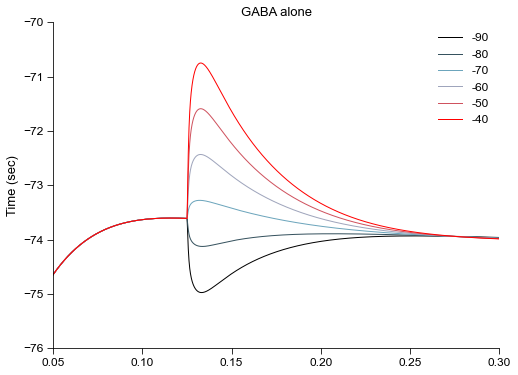

In [39]:
## STOP HERE -- RUN MANUALLY BECAUSE AMP MUST BE CONTROLLED ABOVE

## GABA currents alone
## manually set ahp_plot_axes amp to 0
#percents = [-90]
percents = np.arange(-90,-30,10)
cmap = clr.LinearSegmentedColormap.from_list('scn2a', 
                                             [(0,    'k'),
                                              (0.5, 'skyblue'),
                                              (1,    'red')], N=256)

fig, ax = ahp_plot_axes()
ax.set_prop_cycle('color',cmap(np.linspace(0,1,len(percents))))

nsg.start = 125
for ncg in ncgs:
    ncg.weight[0] = 0.0005
for i, p in enumerate(percents):
    init_settings() ### set conductance here
    for syn in syns:
        syn.e = p
    Vm, I, t = run_model()
    ax.plot(t[int(50/h.dt):int(500/h.dt)], Vm[int(50/h.dt):int(500/h.dt)], linewidth=1, label = '{}'.format(int(p)))

ax.legend(frameon=False)
title='GABA alone'
plt.title(title)
ax.set_ylim(-76,-70)
# plt.savefig(title + '.pdf')
plt.show()

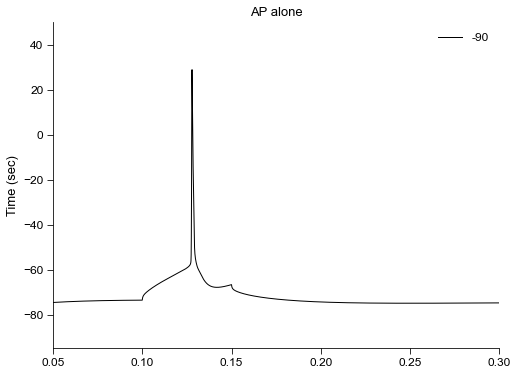

In [56]:
## manually change ahp_plot_axes amp back to 0.45
## spikes alone, no GABA
#percents = np.arange(-90,-30,10)
percents = [-90]
cmap = clr.LinearSegmentedColormap.from_list('scn2a', 
                                             [(0,    'k'),
                                              (0.5, 'skyblue'),
                                              (1,    'red')], N=256)

fig, ax = ahp_plot_axes()
ax.set_prop_cycle('color',cmap(np.linspace(0,1,len(percents))))


## turn off GABA synapses
for ncg in ncgs:
    ncg.weight[0] = 0.0
    
for i, p in enumerate(percents):
    init_settings() ### set conductance here
    for syn in syns:
        syn.e = p
    Vm, I, t = run_model()
    ax.plot(t[int(50/h.dt):int(500/h.dt)], Vm[int(50/h.dt):int(500/h.dt)], linewidth=1, label = '{}'.format(int(p)))

ax.legend(frameon=False)
title='AP alone'
plt.title(title)
# plt.savefig(title + '.pdf')
plt.show()

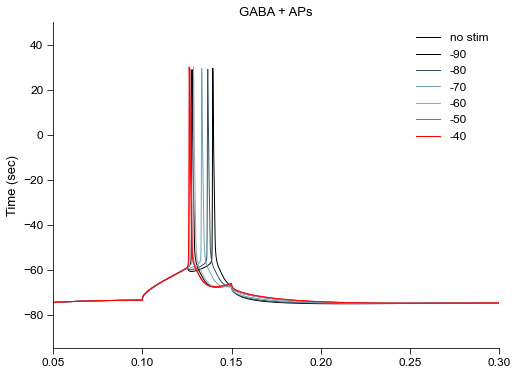

In [58]:
## once calibrated, turn GABA on again
percents = np.arange(-90,-30,10)
#percents = [-90]  ## use for calibration
cmap = clr.LinearSegmentedColormap.from_list('scn2a', 
                                             [(0,    'k'),
                                              (0.5, 'skyblue'),
                                              (1,    'red')], N=256)

fig, ax = ahp_plot_axes()
ax.set_prop_cycle('color',cmap(np.linspace(0,1,len(percents))))


#once without GABA
for ncg in ncgs:
    ncg.weight[0] = 0
init_settings()
Vm, I, t = run_model()
ax.plot(t[int(30/h.dt):int(800/h.dt)], Vm[int(30/h.dt):int(800/h.dt)], linewidth=1, label = 'no stim', color = 'k')

for ncg in ncgs:
    ncg.weight[0] = 0.0005
for i, p in enumerate(percents):
    init_settings() ### set conductance here
    for syn in syns:
        syn.e = p
    Vm, I, t = run_model()
    ax.plot(t[int(30/h.dt):int(800/h.dt)], Vm[int(30/h.dt):int(800/h.dt)], linewidth=1, label = '{}'.format(int(p)))

ax.legend(frameon=False)
title='GABA + APs'
plt.title(title)
# plt.savefig(title + '.pdf')
plt.show()

In [18]:
## way too much current, only 100 ms to calibrate, so move everything forward a bit to shorten run time

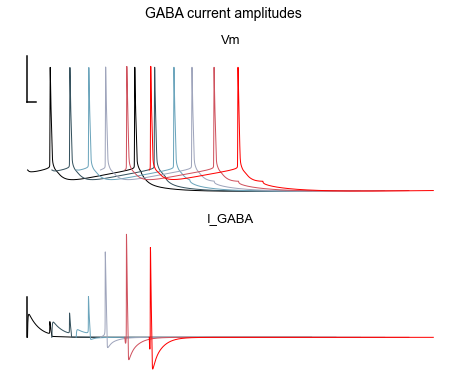

In [60]:
def GABA_current_plots(label):
    ax1.set_title('Vm')
    ax1.set_ylabel('Vm (mV)')
    ax2.set_title('I_GABA')
    ax2.set_xlabel('Time (sec)')
    ax2.set_ylabel('I_GABA (nA)')
#     ax2.set_ylim(0, 0.8)
    
#     ax3.set_title('I_Na')
#     ax3.set_xlabel('Time (sec)')
#     ax3.set_ylabel('I_Na (nA)')
#     ax3.set_ylim(-2.5, 0)

    Vm, I, t = run_model()
    
    t = t[int(nsg.start/h.dt):int(800/h.dt)]
    t = t-t[0]
    Vm = Vm[int(nsg.start/h.dt):int(800/h.dt)]
    I_GABA = I['GABA'][int(nsg.start/h.dt):int(800/h.dt)]
    #I_K = I['K'][spike_start:spike_end]
    
    ax1.plot(t + i*.015, Vm, linewidth = 1, label = label)    
    ax2.plot(t + i*.015, I_GABA, linewidth = 1, label = label)
    #ax3.plot(t + i*.015, I_Na, linewidth = 1, label = label)

sweep_len = 300
stim_dur = 95
stim_start = 100
amp = 0.15
dt = 0.01

init_stim(sweep_len=300, 
          stim_start=stim_start,
          stim_dur=stim_dur,
          amp=amp,
          dt=dt)

fig1, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=(8,6), sharex=False, sharey=False)
fig_title = 'GABA current amplitudes'
fig1.suptitle(fig_title) 

#percents = [-90]
percents = np.arange(-90,-30,10)
cmap = clr.LinearSegmentedColormap.from_list('scn2a', 
                                             [(0,    'k'),
                                              (0.5, 'skyblue'),
                                              (1,    'red')], N=256)

ax1.set_prop_cycle('color',cmap(np.linspace(0,1,len(percents))))
ax2.set_prop_cycle('color',cmap(np.linspace(0,1,len(percents))))
#ax3.set_prop_cycle('color',cmap(np.linspace(0,1,len(percents))))

ax1.plot([0, 0], [0, 40], 'k')
ax1.plot([0, 0.005], [0, 0], 'k')
ax2.plot([0, 0], [0, .2], 'k')
#ax3.plot([0, 0], [0, -0.5], 'k')
#ax3.plot([0, 0], [0, -0.5], 'k')

ax1.axis('off')
ax2.axis('off')
#ax3.axis('off')


for ncg in ncgs:
    ncg.weight[0] = 0.0005
    
for i, p in enumerate(percents):
    init_settings() 
    for syn in syns:
        syn.e = p
    GABA_current_plots(label = '{}'.format(int(p)))
    
# ax1.legend(frameon=False, title='NaV1.2 (%)')
# plt.savefig("{}.pdf".format('model_currents_and_spikes'), transparent=True)
plt.show()

-56.54150621821177
0.12696000000000002
0.12781
0.1273
0.1269
0.12660000000000002
0.1264
0.12624000000000002
0.12612
0.12603
0.12596000000000002
0.1259
0.12585000000000002
0.1258
0.12576
0.12573
0.1257
0.12568000000000001
0.12565
0.12563000000000002
0.12561
0.12559


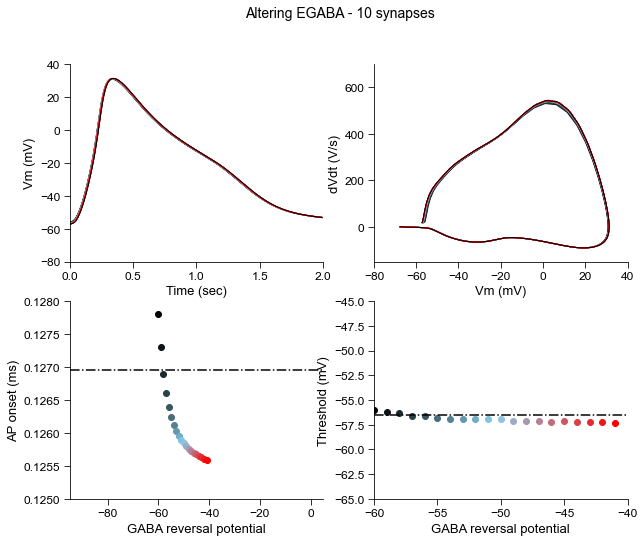

In [78]:
### Anna threshold models continued
# ten GABA synapses

#set all to zero at first
for ncg in ncgs:
    ncg.weight[0] = 0
    
#set color map
cmap = clr.LinearSegmentedColormap.from_list('scn2a', 
                                         [(0,    'k'),
                                          (0.5, 'skyblue'),
                                          (1,    'red')], N=256)

### PLOTS ###
init_stim_for_phase_plane()
#percents = [-90, -80, -70, -60, -50, -40, -30, -20, -10, 0]
percents = np.arange(-60,-40,1)
fig, ax1, ax2, ax3, ax4 = AP1_phase_plane_comparison_axes(percents, cmap)
fig.suptitle('Altering EGABA - 10 synapses')
time = []
thresh = []

# for i, p in enumerate(percents):
#     init_settings(na12=p) ### set conductance here
#     dvdt_temp, thresh_temp = AP1_phase_plane(ax1, ax2, label = '{}%'.format(int(p*100)))
#     dvdt.append(dvdt_temp)
#     thresh.append(thresh_temp)

### run once with no GABA
init_settings()
time_nostim, thresh_nostim = AP1_phase_plane(ax1, ax2, label = 'no stim')
ax3.axhline(y = time_nostim, color = 'k', linestyle = 'dashdot')
ax4.axhline(y = thresh_nostim, color = 'k', linestyle = 'dashdot')
print(thresh_nostim)
print(time_nostim)

#reinstate GABAsyn

for ncg in ncgs:
    ncg.weight[0] = 0.0005

for i, p in enumerate(percents):
    init_settings() 
    for syn in syns:
        syn.e = p
    time_temp, thresh_temp = AP1_phase_plane(ax1, ax2, label = '{}%'.format(int(p*100)))
    time.append(time_temp)
    thresh.append(thresh_temp)

# for i, p in enumerate(reversals):
#     init_settings(GABAsyn.e = p) ### set conductance here
#     dvdt_temp, thresh_temp = AP1_phase_plane(ax1, ax2, label = '{}%'.format(int(p*100)))
#     dvdt.append(dvdt_temp)
#     thresh.append(thresh_temp)

    
#reversals = [-100,-90, -80, -70, -60, -50, -40, -30, -20, -10, 0]
ax3.set_prop_cycle('color', cmap(np.linspace(0,1,len(percents))))
for i in range(len(percents)):
    ax3.scatter(percents[i],time[i])
    print(time[i])
ax3.set_xlim(-95,5)
ax3.set_ylim(0.125,0.128)


ax4.set_prop_cycle('color', cmap(np.linspace(0,1,len(percents))))
for i in range(len(percents)):
    ax4.scatter(percents[i],thresh[i])
ax4.set_xlim(-60,-40) 
ax4.set_ylim(-65,-45)
    
# plt.savefig('Phase-plane - Reducing NaV12 – All Compartments.pdf')
plt.show()

-56.54150621821177
0.12696000000000002
0.13865
0.13579
0.13244999999999998
0.12781
0.12585000000000002
0.12558
0.12546000000000002
0.12539
0.12535000000000002


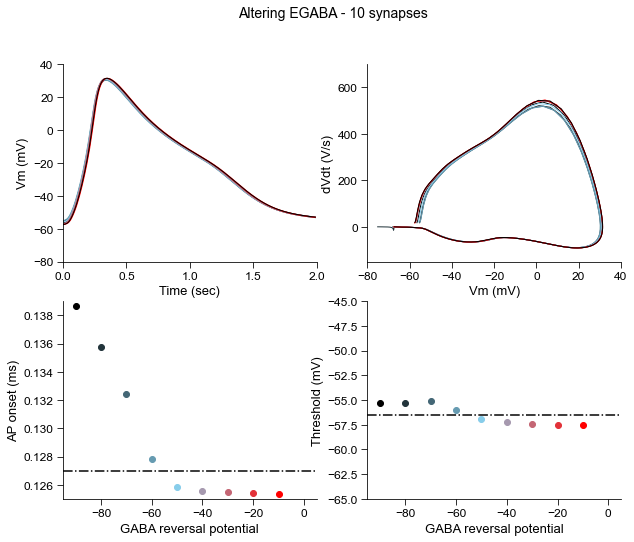

In [79]:
## again with a wider EGABA step
### Anna threshold models continued
# ten GABA synapses

#set all to zero at first
for ncg in ncgs:
    ncg.weight[0] = 0
    
#set color map
cmap = clr.LinearSegmentedColormap.from_list('scn2a', 
                                         [(0,    'k'),
                                          (0.5, 'skyblue'),
                                          (1,    'red')], N=256)

### PLOTS ###
init_stim_for_phase_plane()
#percents = [-90, -80, -70, -60, -50, -40, -30, -20, -10, 0]
percents = np.arange(-90,0,10)
fig, ax1, ax2, ax3, ax4 = AP1_phase_plane_comparison_axes(percents, cmap)
fig.suptitle('Altering EGABA - 10 synapses')
time = []
thresh = []

# for i, p in enumerate(percents):
#     init_settings(na12=p) ### set conductance here
#     dvdt_temp, thresh_temp = AP1_phase_plane(ax1, ax2, label = '{}%'.format(int(p*100)))
#     dvdt.append(dvdt_temp)
#     thresh.append(thresh_temp)

### run once with no GABA
init_settings()
time_nostim, thresh_nostim = AP1_phase_plane(ax1, ax2, label = 'no stim')
ax3.axhline(y = time_nostim, color = 'k', linestyle = 'dashdot')
ax4.axhline(y = thresh_nostim, color = 'k', linestyle = 'dashdot')
print(thresh_nostim)
print(time_nostim)

#reinstate GABAsyn

for ncg in ncgs:
    ncg.weight[0] = 0.0005

for i, p in enumerate(percents):
    init_settings() 
    for syn in syns:
        syn.e = p
    time_temp, thresh_temp = AP1_phase_plane(ax1, ax2, label = '{}%'.format(int(p*100)))
    time.append(time_temp)
    thresh.append(thresh_temp)

# for i, p in enumerate(reversals):
#     init_settings(GABAsyn.e = p) ### set conductance here
#     dvdt_temp, thresh_temp = AP1_phase_plane(ax1, ax2, label = '{}%'.format(int(p*100)))
#     dvdt.append(dvdt_temp)
#     thresh.append(thresh_temp)

    
#reversals = [-100,-90, -80, -70, -60, -50, -40, -30, -20, -10, 0]
ax3.set_prop_cycle('color', cmap(np.linspace(0,1,len(percents))))
for i in range(len(percents)):
    ax3.scatter(percents[i],time[i])
    print(time[i])
ax3.set_xlim(-95,5)
ax3.set_ylim(0.125, 0.139)


ax4.set_prop_cycle('color', cmap(np.linspace(0,1,len(percents))))
for i in range(len(percents)):
    ax4.scatter(percents[i],thresh[i])
    #print(thresh[i])
ax4.set_xlim(-95,5) 
ax4.set_ylim(-65, -45)
    
# plt.savefig('Phase-plane - Reducing NaV12 – All Compartments.pdf')
plt.show()

In [74]:
def run_model_axon_record(start_Vm = -80, loc = 0.3):

    h.finitialize(start_Vm)
    timesteps = int(h.tstop/h.dt)
    
    Vm_axon = np.zeros(timesteps)
    I_axon = {}
    I_axon['Na'] = np.zeros(timesteps)
    I_axon['Ca'] = np.zeros(timesteps)
    I_axon['K'] = np.zeros(timesteps)
    I_axon['GABA'] = np.zeros(timesteps)
    t_axon = np.zeros(timesteps)

    for ii in range(timesteps):
        Vm_axon[ii] = h.cell.axon[0](loc).v
        I_axon['Na'][ii] = h.cell.axon[0](loc).ina
        I_axon['Ca'][ii] = h.cell.axon[0](loc).ica
        I_axon['K'][ii] = h.cell.axon[0](loc).ik
        for syn in syns:
            I_axon['GABA'][ii] += syn.i
        t_axon[ii] = ii*h.dt / 1000
        h.fadvance()
     
    ## if GABA currents are present, measure them -- does this work as expected?

#     ivecs = [] # for the individual synaptic currents
#     for abc in syns:
#         tmp = h.Vector()
#         tmp.record(abc._ref_i)
#         ivecs.append(tmp)
            
#     iGABA = np.zeros(timesteps)
#     for abc in ivecs:
#         iGABA += abc.as_numpy()
        
    return Vm_axon, I_axon, t_axon

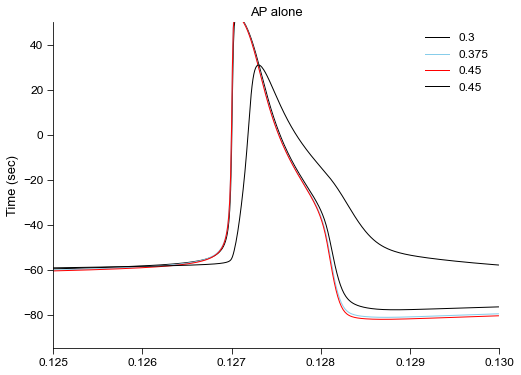

In [77]:
## add several axonal recording electrodes to find AP initiation site

## manually change ahp_plot_axes amp back to 0.25
## spikes alone, no GABA
#percents = np.arange(-90,-30,10)
percents = [0.3, 0.375, 0.45]
cmap = clr.LinearSegmentedColormap.from_list('scn2a', 
                                             [(0,    'k'),
                                              (0.5, 'skyblue'),
                                              (1,    'red')], N=256)

fig, ax = ahp_plot_axes()
ax.set_prop_cycle('color',cmap(np.linspace(0,1,len(percents))))

## turn off GABA synapses
for ncg in ncgs:
    ncg.weight[0] = 0.0
    
for i,p in enumerate(percents):
    Vm_axon, I_axon, t_axon = run_model_axon_record(loc = p)
    ax.plot(t_axon[int(110/h.dt):int(130/h.dt)], Vm_axon[int(110/h.dt):int(130/h.dt)], linewidth=1, label = '{}'.format(p))

init_settings() ### set conductance here
Vm, I, t = run_model()
ax.plot(t[int(110/h.dt):int(130/h.dt)], Vm[int(110/h.dt):int(130/h.dt)], linewidth=1, label = '{}'.format(p))
    
ax.legend(frameon=False)
ax.set_xlim(0.125, 0.13)
title='AP alone'
plt.title(title)
# plt.savefig(title + '.pdf')
plt.show()

-56.49062549796888
0.12825
0.13961
0.13675
0.13341
0.12890000000000001
0.12606
0.12567
0.12553
0.12544
0.12539


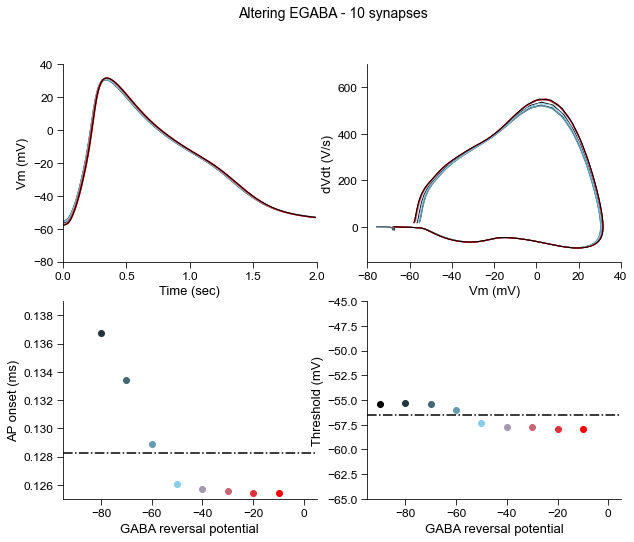

In [80]:
## remove all passive conductances
gpas_reduct = 0

## again with a wider EGABA step
### Anna threshold models continued
# ten GABA synapses

#set all to zero at first
for ncg in ncgs:
    ncg.weight[0] = 0
    
#set color map
cmap = clr.LinearSegmentedColormap.from_list('scn2a', 
                                         [(0,    'k'),
                                          (0.5, 'skyblue'),
                                          (1,    'red')], N=256)

### PLOTS ###
init_stim_for_phase_plane()
#percents = [-90, -80, -70, -60, -50, -40, -30, -20, -10, 0]
percents = np.arange(-90,0,10)
fig, ax1, ax2, ax3, ax4 = AP1_phase_plane_comparison_axes(percents, cmap)
fig.suptitle('Altering EGABA - 10 synapses')
time = []
thresh = []

# for i, p in enumerate(percents):
#     init_settings(na12=p) ### set conductance here
#     dvdt_temp, thresh_temp = AP1_phase_plane(ax1, ax2, label = '{}%'.format(int(p*100)))
#     dvdt.append(dvdt_temp)
#     thresh.append(thresh_temp)

### run once with no GABA
init_settings(gpas_all = gpas_reduct)
time_nostim, thresh_nostim = AP1_phase_plane(ax1, ax2, label = 'no stim')
ax3.axhline(y = time_nostim, color = 'k', linestyle = 'dashdot')
ax4.axhline(y = thresh_nostim, color = 'k', linestyle = 'dashdot')
print(thresh_nostim)
print(time_nostim)

#reinstate GABAsyn

for ncg in ncgs:
    ncg.weight[0] = 0.0005

for i, p in enumerate(percents):
    init_settings(gpas_all = gpas_reduct) 
    for syn in syns:
        syn.e = p
    time_temp, thresh_temp = AP1_phase_plane(ax1, ax2, label = '{}%'.format(int(p*100)))
    time.append(time_temp)
    thresh.append(thresh_temp)

# for i, p in enumerate(reversals):
#     init_settings(GABAsyn.e = p) ### set conductance here
#     dvdt_temp, thresh_temp = AP1_phase_plane(ax1, ax2, label = '{}%'.format(int(p*100)))
#     dvdt.append(dvdt_temp)
#     thresh.append(thresh_temp)

    
#reversals = [-100,-90, -80, -70, -60, -50, -40, -30, -20, -10, 0]
ax3.set_prop_cycle('color', cmap(np.linspace(0,1,len(percents))))
for i in range(len(percents)):
    ax3.scatter(percents[i],time[i])
    print(time[i])
ax3.set_xlim(-95,5)
ax3.set_ylim(0.125, 0.139)


ax4.set_prop_cycle('color', cmap(np.linspace(0,1,len(percents))))
for i in range(len(percents)):
    ax4.scatter(percents[i],thresh[i])
    #print(thresh[i])
ax4.set_xlim(-95,5) 
ax4.set_ylim(-65, -45)
    
# plt.savefig('Phase-plane - Reducing NaV12 – All Compartments.pdf')
plt.show()